<a href="https://colab.research.google.com/github/nenomg/Bollinger-bands-strategy/blob/main/Estrategia_BOLL%2BRSI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Importación de las librerías

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

2. Funciones

2.1 Bollinger bands.

Devuelve la banda de arriba y la de abajo en base al precio típico ((High + Low + Close)/3).

In [ ]:
def bollingerBands(data, m, n):
    res = []
    res2 = []
    j = 0
    for i in range(m, len(data)):
        tp = ((data.Close[j:i] + data.High[j:i] + data.Low[j:i]) / 3)
        
        res.append(np.mean(tp) + n * np.std(tp))
        res2.append(np.mean(tp) - n * np.std(tp))
        j = j + 1
    
    return res, res2

2.2 RSI

Calcula el RSI en base a la media movil exponencial o la media movil simple.

In [ ]:
def rsi(df, periods = 14, ema = True):
    close_delta = df['Close'].diff()

    up = close_delta.clip(lower=0)
    down = -1 * close_delta.clip(upper=0)
    
    if ema == True:
        ma_up = up.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
        ma_down = down.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
    else:
        #Simple moving average
        ma_up = up.rolling(window = periods).mean()
        ma_down = down.rolling(window = periods).mean()
        
    rsi = ma_up / ma_down
    rsi = 100 - (100/(1 + rsi))
    return rsi

3. Leemos el dataset de BTC

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Estrategia/BTCEUR_4HOUR.csv",low_memory=False, names = ["Date","Open","High", "Low", "Close", "Vol","quote_asset_volume", "num_trades", "taker_buy_base_asset_volume", "taker_buy_quote_asset_volume"]);
data = data[1::]
data = data.reset_index(drop=True)
data.head()

,Date,Open,High,Low,Close,Vol,quote_asset_volume,num_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume
0,2020-01-03 08:00:00,6244.33,6607.39,6244.33,6581.57,2.541087,16670.12619614,74,1.26971300,8355.36962710
1,2020-01-03 12:00:00,6552.79,6581.57,6494.83,6505.82,0.202788,1323.44333801,17,0.08147500,530.76692799
2,2020-01-03 16:00:00,6608.59,6608.59,6542.05,6550.23,0.30663,2012.00561838,15,0.25996500,1705.54681898
3,2020-01-03 20:00:00,6567.81,6568.73,6516.32,6568.73,0.508475,3329.90744696,18,0.21038800,1377.84651950
4,2020-01-04 00:00:00,6558.96,6559.15,6533.6,6533.6,0.084964,556.00430380,10,0.01469900,96.30254388


In [ ]:
print("Shape: ", data.shape)

Shape:  (4557, 10)


3.1 Convertimos a numerico el dataset.

In [ ]:
data[["Open","High", "Low", "Close", "Vol","quote_asset_volume", "num_trades", "taker_buy_base_asset_volume", "taker_buy_quote_asset_volume"]] = data[["Open","High", "Low", "Close", "Vol","quote_asset_volume", "num_trades", "taker_buy_base_asset_volume", "taker_buy_quote_asset_volume"]].apply(pd.to_numeric)

4. Definimos las variables de las bollinger bands ya que son necesarias para la longitud del dataset, eliminaremos las filas que sean de una fecha menor, es decir las primeras.

In [ ]:
m = 12
smoothing = 2

5. Calculamos RSI

In [ ]:
rsi_BTC = rsi(data, 5)
rsi_BTC = rsi_BTC[(5 + m):len(rsi_BTC)]
rsi_BTC = rsi_BTC.reset_index(drop=True)
len(rsi_BTC)

4540

Mostramos las primeras filas de RSI.

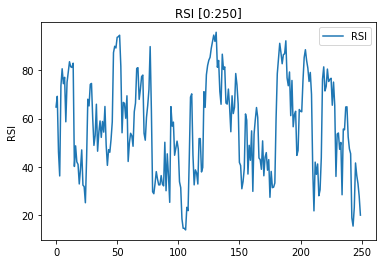

In [ ]:
plt.ylabel('RSI')
plt.plot(rsi_BTC[0:250], label="RSI")
plt.legend()
plt.title("RSI [0:250]")
plt.show()

6. Calculamos las Bollinger Bands y le quitamos las 14 filas eliminadas en el RSI y a data le restamos lo del RSI y de las BOLL.

In [ ]:
b_u, b_d = bollingerBands(data, m, smoothing)
b_u = b_u[14:len(b_u)]
b_d = b_d[14:len(b_d)]

data = data[(14 + m):len(data)]
data = data.reset_index(drop=True)

Mostramos las primeras filas de las Bollinger Bands.

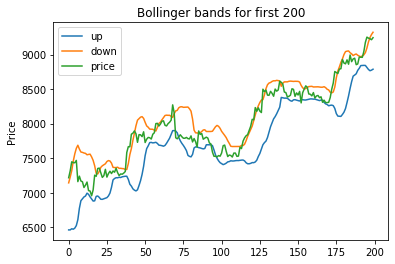

In [ ]:
plt.ylabel('Price')
plt.plot(np.arange(0,200), b_d[0:200], label="up")
plt.plot(np.arange(0,200), b_u[0:200], label="down")
plt.plot(data["Close"][0:200], label="price")
plt.legend()
plt.title('Bollinger bands for first 200')
plt.show()

7. Comenzamos la estrategia.

Cuando choca la banda del precio(Verde) con la banda de abajo(Azul) esperamos a que vuelvan a chocar y cuando lo hagan miramos si el RSI nos da el visto bueno para invertir, entonces compramos y vendemos cuando choque arriba.

In [ ]:
buys_idx = []
sells_idx = []

prev_price = -1
d_band = False
u_band = False
buy = False
d_band2 = False
sell = False
res = 0
percentages = []
            
            
for i in range(0, len(data)):
  #SI CRUZA CON LA BANDA DE ABAJO Y NO SE HA COMPRADO ACTIVA D_BAND
  if data.iloc[i]["Close"] < b_d[i] and d_band == False and u_band == False and buy == False:
    d_band = True
                    
  #COMPRA SI VUELVE A CRUZAR CON LA BANDA DE ABAJO Y D_BAND ESTA ACTIVADO COMPRA
  elif data.iloc[i]["Close"] > b_d[i] and d_band == True and buy == False:
    prev_price = data.iloc[i]["Close"]
    buy = True
    d_band = False
    sell = False
    buys_idx.append(i)
                    
  #SI SE HA COMPRADO Y CRUZA ARRIBA ACTIVA U_BAND
  elif data.iloc[i]["Close"] > b_u[i] and u_band == False and d_band == False and buy == True:
    u_band = True
                    
  #SI CRUZA CON LA BANDA DE ARRIBA DE NUEVO VENDE
  elif data.iloc[i]["Close"] < b_u[i] and u_band == True and buy == True and sell == False:
    res = res + ((data.iloc[i]["Close"] - prev_price) / prev_price)
    #CALCULAMOS LA DIFERENCIA ENTRE COMPRA Y VENTA
    percentages.append((data.iloc[i]["Close"] / prev_price))
    buy = False
    u_band = False
    sell = True
    prev_price = -1
    sells_idx.append(i)

Imprimimos las compras y ventas, compras en rojo ventas en azul

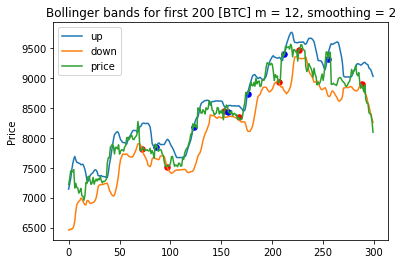

In [ ]:
def plotBuysAndSells(b_d, b_u, price, name, m, smoothing, buys_idx, sells_idx):
    
    margin_d = 0
    margin_u = 300
    
    buys = []
    buys_p = []
    for i in range(0, len(buys_idx)):
        if buys_idx[i] >= margin_d and buys_idx[i]<=margin_u:
            buys.append(price[buys_idx[i]])
            buys_p.append(buys_idx[i])
    sells = []
    sells_p = []
    for i in range(0, len(sells_idx)):
        if sells_idx[i] >= margin_d and sells_idx[i]<=margin_u:
            sells.append(price[sells_idx[i]])
            sells_p.append(sells_idx[i])
    
    
    
    plt.ylabel('Price')
    plt.plot(np.arange(margin_d,margin_u), b_u[margin_d:margin_u], label="up")
    plt.plot(np.arange(margin_d,margin_u), b_d[margin_d:margin_u], label="down")
    plt.plot(price[margin_d:margin_u], label="price")
    
    
    plt.scatter(buys_p, buys,s = 30, marker='o', c="red")
    plt.scatter(sells_p, sells,s=30, marker='o', c="blue")
    
    plt.legend()
    plt.title('Bollinger bands for first 200 [' + name + '] m = ' + str(m) + ", smoothing = "+ str(smoothing))
    plt.show()


plotBuysAndSells(b_d, b_u, data["Close"], "BTC", m, smoothing, buys_idx, sells_idx)

8. Calculamos los resultados obtenidos.

In [ ]:
unidad = 1
for i in range(0, len(percentages)):
  unidad = unidad * percentages[i]

print("m = ",m, "| smoothing = ",  smoothing, "| Unidad: ", unidad)

m =  12 | smoothing =  2 | Unidad:  2.349324763017155


In [ ]:
unidad = 500
for i in range(0, len(percentages)):
  unidad = unidad * percentages[i] - 0.40;

print("m = ",m, "| smoothing = ",  smoothing, "| Unidad: ", unidad)

m =  12 | smoothing =  2 | Unidad:  1119.1795876100164
